In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## imports 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import random
import json
import regex as re
import pprint
from collections import defaultdict
import sys
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import gensim.downloader as api
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


In [ ]:
!ls
path = '/content/drive/MyDrive/reviews_Movies_and_TV.json'

drive  sample_data


In [ ]:
# !pip install ijson

In [ ]:
### chunks
chunks = pd.read_json(path, lines=True, chunksize=10000)
for chunk in chunks:
    print(chunk.columns)
    break

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')


In [ ]:
class Tokeniser():
    def __init__(self):
        pass
    
    def convert_text_to_string(self):
        self.text = '\n'.join(self.text)
        self.text = re.sub(r'\n+', r'\.', self.text)
    
    def lower_case(self):
        self.text = self.text.lower()
    
    def remove_punctuations(self):
        self.text = re.sub(r'[^\w+^\.^\?^\!\s]', r'', self.text)
        return self.text
        
    def handle_special_cases(self):
        self.text = re.sub(r'(\w+)\'bout', r'\1 about', self.text)
        self.text=re.sub(r"won\'t","will not",self.text)
        self.text = re.sub(r'(\w+)\'t', r'\1 not', self.text)
        self.text = re.sub(r'(\w+)\'s', r'\1 is', self.text)
        self.text = re.sub(r'(\w+)\'re', r'\1 are', self.text)
        self.text = re.sub(r'(\w+)\'ll', r'\1 will', self.text)
        self.text = re.sub(r'(\w+)\'d', r'\1 would', self.text)
        self.text = re.sub(r'(\w+)\'ve', r'\1 have', self.text)
        self.text = re.sub(r'([iI])\'m', r'\1 am', self.text)
        
    def remove_stupid_fullstop(self):
        self.text=re.sub("Mr\s*\.","Mr",self.text)
        self.text=re.sub("Ms\s*\.","Ms",self.text)
        self.text=re.sub("Mrs\s*\.","Mrs",self.text)
        self.text=re.sub("Miss\s*\.","Miss",self.text)
        
    def remove_extra_spaces(self):
        self.text = re.sub(' +', ' ', self.text)
        
    def split_into_sentences(self):
        self.text = re.split('\w*\.\w* | \w*\?\w* | \w*\!\w*', self.text)
        # self.text = re.split('\w*\. | \w*\?', self.text)
        
    def remove_empty_chars(self):
        for i in self.text:
            if i == '':
                self.text.remove(i)
        
    def tokenise(self):
        self.convert_text_to_string()
        self.remove_stupid_fullstop()
        self.lower_case()
    
    def modify_text(self, text):
        self.text = text
        self.tokenise()
        self.remove_punctuations()
        self.handle_special_cases()
        self.remove_extra_spaces()
        self.split_into_sentences()
        self.remove_empty_chars()
        return self.text

In [ ]:
class TextProcessing():
    def __init__(self, path, sentences, pad_val=0):
        self.path = path
        self.sentences = sentences
        self.vocab = set()
        self.corpus = set()
        self.start_token = '<START>'
        self.end_token = '<END>'
        self.tokeniser = Tokeniser()
        self.pad_val = pad_val
        
    def load_data(self):
        self.chunks = pd.read_json(self.path, lines=True, chunksize=10000)
        
    def read_data(self):
        check = False
        for chunk in self.chunks:
            text = chunk['reviewText']
            for sentences in text:
                sentences = sentences.split('.')
                for sent in sentences:
                    self.corpus.add(sent)
                if len(self.corpus) > self.sentences:
                    check = True
                    break
            if check:
                self.corpus = list(self.corpus)
                break
            
        for i in self.corpus:
            if len(i.split()) < 2:
                self.corpus.remove(i)
        self.final_sentences = len(self.corpus)
        self.corpus = self.tokeniser.modify_text(self.corpus)
        self.corpus = [[self.start_token]+[word for word in sentence.split()]+[self.end_token] for sentence in self.corpus]
    
    def build_vocab(self):
        self.vocab = sorted(list(set([word for doc in self.corpus for word in doc])))
        self.word_to_idx = defaultdict(int)
        for doc in self.corpus:
            for word in doc:
                self.word_to_idx[word] += 1
        for k in list(self.word_to_idx.keys()):
            if ('!' in k):
                del self.word_to_idx[k]
            elif self.word_to_idx[k] == 1:
                self.word_to_idx['<UNK>'] += 1
                del self.word_to_idx[k]
        self.word_to_idx = dict(sorted(self.word_to_idx.items(), key=lambda x:x[0]))
        self.widx = self.word_to_idx.copy()
        self.word_to_idx = {word: i+1 for i,word in enumerate(list(self.word_to_idx.keys()))}
        self.word_to_idx['<pad>'] = self.pad_val
        self.idx_to_word = {i+1:word for i,word in enumerate(list(self.widx.keys()))}
        self.idx_to_word[0] = '<pad>'
        self.vocab = list(self.word_to_idx.keys())
        self.num_words = len(self.vocab)


    def indenture(self):
        self.load_data()
        self.read_data()
        self.build_vocab()

In [ ]:
class SVD():
    def __init__(self, corpus, dict, vocab, num_words, embedding_dim=2, window_size=4):
        self.corpus = corpus
        self.word_to_idx = dict
        self.vocab = vocab
        self.num_words = num_words
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.unk_word = '<UNK>'
    
    def build_cooc_mat(self):
        self.cooc_mat = np.zeros((self.num_words, self.num_words), dtype=np.int32)
        print('building cooc matrix')
        for doc in self.corpus:
            doc_size = len(doc)
            for cur_doc_idx in range(doc_size):
                l = max(0, cur_doc_idx - self.window_size)
                r = min(doc_size - 1, cur_doc_idx + self.window_size)
                w = doc[cur_doc_idx]
                try:
                    dict_idx = self.word_to_idx[w]
                except:
                    dict_idx = self.word_to_idx[self.unk_word]
                outside_words = doc[l:cur_doc_idx]+doc[cur_doc_idx+1:r+1]
                for i in outside_words:
                    try:
                        i_idx = self.word_to_idx[i]
                    except:
                        i_idx = self.word_to_idx[self.unk_word]
                    self.cooc_mat[i_idx, dict_idx] += 1
                    self.cooc_mat[dict_idx, i_idx] += 1
    
    def cal_svd(self):
        print('calculating svd')
        svd_inst = TruncatedSVD(n_components=self.embedding_dim, n_iter=10)
        self.word_embeddings = svd_inst.fit_transform(self.cooc_mat)
        # U, s, Vt = np.linalg.svd(self.cooc_mat)
        # self.word_embeddings = U[:, :self.embedding_dim] * np.sqrt(s[:self.embedding_dim])
      
    def indenture(self):
        self.build_cooc_mat()  
        self.cal_svd()

In [ ]:
sentences = 45000
# path = '/media/hitesh/DATA/IIIT-H/3rd_year/INLP/A3/reviews_Movies_and_TV.json'
textProcesser = TextProcessing(path, sentences)
textProcesser.indenture()
pprint.pprint(textProcesser.corpus[:5], compact=True, width=100)

[['<START>', 'it', 'was', 'a', 'very', 'emotional', 'and', 'very', 'touching', 'example', 'of',
  'love', 'and', 'how', 'we', 'as', 'human', 'beings', 'should', 'be', 'in', 'this', 'world', 'of',
  '<END>'],
 ['<START>', 'the', 'default', 'language', 'is', 'latinaramaichebrew', 'with', 'english', '<END>'],
 ['<START>', 'pilate', 'is', 'extraordinarily', 'conflicted', 'about', 'jesus', 'seeming', 'to',
  'believe', 'in', 'the', 'qualities', 'jesus', 'claims', 'to', '<END>'],
 ['<START>', 'it', 'gets', 'to', 'the', 'cause', 'of', 'the', 'problem', 'and', 'corrects',
  '<END>'],
 ['<START>', 'i', 'heartily', 'recommend', 'it', 'for', 'your', 'holiday', 'dvd', '<END>']]


In [ ]:
# pprint.pprint(textProcesser.vocab, compact=True, width=100)

In [ ]:
print(textProcesser.num_words)

13519


In [ ]:
print(textProcesser.word_to_idx)
d = textProcesser.word_to_idx
count = 0
tot = 0
for k,v in d.items():
    tot += 1
    if v < 2:
        count += 1
count, tot

{'+': 1, '1': 2, '10': 3, '100': 4, '1000': 5, '10000': 6, '1000s': 7, '101': 8, '1012': 9, '1015': 10, '103': 11, '1080p': 12, '11': 13, '110': 14, '1138': 15, '114': 16, '117': 17, '11822': 18, '12': 19, '120': 20, '126': 21, '127': 22, '12step': 23, '12story': 24, '12th': 25, '13': 26, '13th': 27, '14': 28, '145': 29, '14th': 30, '15': 31, '150': 32, '1513': 33, '152': 34, '1520': 35, '16': 36, '17': 37, '1722': 38, '17th': 39, '18': 40, '1830s': 41, '1840s': 42, '185': 43, '18th': 44, '19': 45, '1930s': 46, '193233': 47, '1933': 48, '1939': 49, '1940': 50, '1940s': 51, '1941': 52, '1951': 53, '1960': 54, '1960s': 55, '1961': 56, '1964': 57, '1965': 58, '1966': 59, '1967': 60, '1968': 61, '1969': 62, '1970': 63, '1970s': 64, '1971': 65, '1977': 66, '1979': 67, '1980': 68, '1980s': 69, '1982': 70, '1984': 71, '1985': 72, '1986': 73, '1987': 74, '1988': 75, '1989': 76, '1990': 77, '1990s': 78, '1992': 79, '1993': 80, '1994': 81, '1995': 82, '1996': 83, '1997': 84, '1998': 85, '1999': 

(2, 13519)

In [ ]:
svd = SVD(textProcesser.corpus, textProcesser.word_to_idx, textProcesser.vocab, textProcesser.num_words, embedding_dim=50)
svd.indenture()

building cooc matrix
calculating svd


In [ ]:
print(svd.word_embeddings)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.07668830e+00 -1.01887947e+00 -7.61998864e-01 ...  3.66829030e-01
   3.54111577e-01  4.01367520e-01]
 [ 6.32512317e+01 -6.92069065e-02 -4.96427822e+00 ...  1.78168576e+00
   3.27567468e+00 -2.65630076e+00]
 ...
 [ 1.01080041e+00  6.27211295e-01 -8.11262864e-01 ... -1.18684274e-01
  -5.25208848e-02  4.46231446e-02]
 [ 1.14029593e+01 -5.92546308e-02 -5.16763240e+00 ... -1.04092957e+00
   5.16371485e-01  1.08886001e+00]
 [ 9.48213848e+00  1.50261638e+00 -2.39486124e+00 ... -8.95455278e-01
   6.44126853e-02  6.71758365e-02]]


In [ ]:
print(type(svd.word_embeddings))
with open('svd.npy', 'wb') as f:
    np.save(f, svd.word_embeddings, allow_pickle=True)

<class 'numpy.ndarray'>


In [ ]:
def plot(word_embeddings, word_to_idx, words):
    for word in words:
        try:
            idx = word_to_idx[word]
        except:
            idx = word_to_idx['<UNK>']
        x, y = word_embeddings[idx]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x,y,word,fontsize=9)
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

word_embeddings = svd.word_embeddings
word_to_idx = textProcesser.word_to_idx
idx_to_word = textProcesser.idx_to_word

word_embeddings = scaler.fit_transform(word_embeddings)
words = ["funny", "hilarious", "good", "bad", "king", "beggar", "titanic", "giant"]

# plot(word_embeddings, word_to_idx, words)

In [ ]:
import gensim.downloader as api

word = 'titanic'
# Download the pre-trained embeddings
pretrained_model = api.load("word2vec-google-news-300")

In [ ]:
# Get the top 10 closest words to "titanic" in the pre-trained embeddings
word = "camera"
pretrained_closest_words = pretrained_model.most_similar(word, topn=10)

In [ ]:
print(f"Closest words to {word} according to word2vec:")
for i in pretrained_closest_words:
    print(i)

Closest words to camera according to word2vec:
('cameras', 0.8131939172744751)
('Wagging_finger', 0.7311819791793823)
('camera_lens', 0.7250816822052002)
('camcorder', 0.7037474513053894)
('Camera', 0.6848659515380859)
('Canon_digital_SLR', 0.6474252939224243)
('Cameras', 0.6350969076156616)
('Nikon_D####_digital_SLR', 0.6259366273880005)
('tripod', 0.6189837455749512)
('EyeToy_USB', 0.6173486709594727)


In [ ]:
from sklearn.neighbors import NearestNeighbors
def find_nearest_words(word_embeddings, word_to_idx, idx_to_word, word, num=10):
    try:
        idx = word_to_idx[word]
    except:
        idx = word_to_idx['<UNK>']
    similarity_scores = cosine_similarity(word_embeddings[idx].reshape(1, -1), word_embeddings)
    top_indices = similarity_scores.argsort()[0][::-1][:num+1]
    tops = [idx_to_word[i] for i in top_indices]
    return tops

In [ ]:
word = "titanic"
closest_words = find_nearest_words(word_embeddings, word_to_idx, idx_to_word, word)
print(f"Closest words to {word} accroding to SVD:")
for i in closest_words:
    print(i)

Closest words to titanic accroding to SVD:
titanic
persecuting
auto
ventures
boiling
playback
graham
opinionated
jeffrey
godless
claymations


In [ ]:
class Datasets():
    def __init__(self, vocab, corpus, word_to_idx, idx_to_word, pad_val, window_size=2):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.corpus = corpus
        self.word_to_idx = word_to_idx
        self.idx_to_word = idx_to_word
        self.window_size = window_size
        self.unk_word = '<UNK>'
        self.data = list()
        # self.data_skip = list()
        self.pad_val = pad_val

    def padding(self):
        # CBOW
        self.context = [sent[0] for sent in self.data]
        self.words = np.array([sent[1] for sent in self.data])
        self.target = np.array([sent[2] for sent in self.data])
        max_len = max(len(arr) for arr in self.context)
        for ind, arr in enumerate(self.context):
            x = max_len - len(arr)
            for _ in range(x):
                self.context[ind].append(self.pad_val)
        self.data.clear()
        for ind, i in enumerate(self.context):
            self.data.append((i, self.words[ind], self.target[ind]))

        for ind, i in enumerate(self.data):
            self.data[ind] = (torch.tensor(self.data[ind][0]), torch.tensor(self.data[ind][1]), torch.tensor(self.data[ind][2]))

    def create_cbow_dataset(self):
        len_corpus = len(self.corpus)
        for doc_ind, doc in enumerate(self.corpus):
            doc_size = len(doc)
            for cur_doc_idx in range(doc_size):
                l = max(0, cur_doc_idx - self.window_size)
                r = min(doc_size - 1, cur_doc_idx + self.window_size)
                w = doc[cur_doc_idx]
                try:
                    dict_idx = self.word_to_idx[w]
                except:
                    dict_idx = self.word_to_idx[self.unk_word]
                outside_words = doc[l:cur_doc_idx]+doc[cur_doc_idx+1:r+1]
                i_idx_arr = list()
                for i in outside_words:
                    try:
                        i_idx = self.word_to_idx[i]
                    except:
                        i_idx = self.word_to_idx[self.unk_word]
                    i_idx_arr.append(i_idx)
                self.data.append((i_idx_arr, dict_idx, 1))

                # negative sampling
                neg_arr = []
                for _ in range(4):
                    ind = random.randint(1, len_corpus -1)
                    doc_ind_neg = (doc_ind + ind) % len_corpus
                    doc_neg = self.corpus[doc_ind_neg]
                    rand_id = random.randint(0, len(doc_neg) - 1)
                    word_neg = doc_neg[rand_id]
                    try:
                        ind_word_neg = self.word_to_idx[word_neg]
                    except:
                        ind_word_neg = self.word_to_idx[self.unk_word]
                    neg_arr.append(ind_word_neg)
                self.data.append((neg_arr, dict_idx, 0))

    def work(self):
        self.create_cbow_dataset()
        self.padding()

In [ ]:
word_to_idx = textProcesser.word_to_idx
idx_to_word = textProcesser.idx_to_word
vocab = textProcesser.vocab
PAD_VALUE = 0
cbow = Datasets(vocab, textProcesser.corpus, word_to_idx, idx_to_word,PAD_VALUE)
cbow.work()

In [ ]:
c = 0
for ind, i in enumerate(cbow.data):
    print(i)
    c+=1
    if c>10:
        break

(tensor([12079, 13170,     0,     0]), tensor(251), tensor(1))
(tensor([12606,   250,    54,  7807]), tensor(251), tensor(0))
(tensor([  251, 13170,  5899,     0]), tensor(12079), tensor(1))
(tensor([12220, 12042,  4700,  1765]), tensor(12079), tensor(0))
(tensor([  251, 12079,  5899,  7514]), tensor(13170), tensor(1))
(tensor([ 7633, 12040,   250, 12040]), tensor(13170), tensor(0))
(tensor([12079, 13170,  7514,  8251]), tensor(5899), tensor(1))
(tensor([  250, 12813,   250,  8251]), tensor(5899), tensor(0))
(tensor([13170,  5899,  8251,   256]), tensor(7514), tensor(1))
(tensor([ 250, 5591,  250, 6497]), tensor(7514), tensor(0))
(tensor([5899, 7514,  256, 8036]), tensor(8251), tensor(1))


In [ ]:
class cbow_word2vec(nn.Module):
    def __init__(self, vocab_size, embed_size, pad_val):
        super(cbow_word2vec, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=pad_val)
        self.in_embeddings.weight.data.uniform_(-1, 1)
        
    def forward(self, i, o):
        # in_embeds = self.in_embeddings(i).sum(dim=1)
        in_embeds = self.in_embeddings(i)
        out_embeds = self.in_embeddings(o)
        # print(in_embeds.shape, out_embeds.shape)
        score = torch.mm(in_embeds, torch.t(out_embeds))
        probs = F.logsigmoid(score)
        return probs
    # def __init__(self, vocab_size, embed_size, pad_val):
    #     super(cbow_word2vec, self).__init__()
    #     self.in_embeddings = nn.Embedding(vocab_size, embed_size)
    #     self.l1 = nn.Linear(5*embed_size, 64)
    #     self.l2 = nn.Linear(64, 1)
    #     # self.relu = nn.ReLU()
    #     self.relu = nn.LeakyReLU()
    #     self.sigmoid = nn.Sigmoid()
    #     nn.init.uniform_(self.in_embeddings.weight, -1.0, 1.0)

    # def forward(self, i, o):
    #     i = self.in_embeddings(i)
    #     o = self.in_embeddings(o).unsqueeze(dim=1)

    #     embeds = torch.concat((i, o), 1)
    #     embeds = embeds.flatten(start_dim=1)
    #     l1 = self.relu(self.l1(embeds))
    #     l2 = self.l2(l1)
    #     probs = self.sigmoid(l2)
    #     return probs

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
class CBOW_model():
    def __init__(self, vocab_size, data, pad_val=0, hidden_size=64, batch_size=512,lr=0.001, num_epochs=5, window_size=2, embedding_size=100):
        self.vocab_size = vocab_size
        self.data = data
        self.pad_val = pad_val
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.w2v = cbow_word2vec(vocab_size, embedding_size, pad_val).to(device)
        # self.w2v = cbow_word2vec(vocab_size, self.hidden_size, pad_val).to(device)

    def train_cbow_word2vec(self):
        dataload = DataLoader(self.data, batch_size=self.batch_size, num_workers=0)
        # loss_func = nn.NLLLoss().to(device)
        loss_func = nn.BCELoss().to(device)
        optim = torch.optim.Adam(params=self.w2v.parameters(), lr=self.lr, weight_decay=1e-4)
        for epoch in tqdm(range(self.num_epochs), desc='epoch'):
            self.w2v.train()
            total_loss = 0
            total_acc = 0
            for ind, i in enumerate(dataload):
                context, word, target = map(lambda x:x.to(device), i)
                # print(context.shape)
                optim.zero_grad()
                pred = self.w2v(context, word).flatten()
                # pred = torch.argmax(pred, dim=1)
                # print(type(pred), type(target))
                loss = loss_func(pred, target.float())

                loss.backward()
                optim.step()
                total_loss += loss.item() 
                # for val in range(4):
                #     x = context[:, val]
                #     optim.zero_grad()
                #     pred = self.w2v(x, word)
                #     loss = loss_func(pred, target)

                #     loss.backward()
                #     optim.step()

                #     total_loss += loss.item() 
            print(f'\tEpoch {epoch + 1}\tTrain Loss: {total_loss/len(dataload)}')
        torch.save(self.w2v.state_dict(), 'cbow_w2v.pth')

    def load_model(self):
        self.w2v.load_state_dict(
            torch.load(
                "/content/drive/MyDrive/cbow_w2v.pth", map_location=torch.device("cpu")
            )
        )
        return self.w2v.state_dict()

    def nearest_words(self,word, word_to_idx, idx_to_word, num=10):
        embeddings = self.w2v.in_embeddings.weight.data.cpu().numpy()
        try:
            idx = word_to_idx[word]
        except:
            idx = word_to_idx['<UNK>']
        similarity_scores = cosine_similarity(embeddings[idx].reshape(1, -1), embeddings)
        top_indices = similarity_scores.argsort()[0][::-1][:num+1]
        tops = [idx_to_word[i] for i in top_indices]
        return tops

In [ ]:
w2v_cbow = CBOW_model(cbow.vocab_size, cbow.data)

In [ ]:
w2v_cbow.train_cbow_word2vec()

epoch:  20%|██        | 1/5 [00:13<00:54, 13.53s/it]

	Epoch 1	Train Loss: 0.2714476674527824


epoch:  40%|████      | 2/5 [00:26<00:39, 13.06s/it]

	Epoch 2	Train Loss: 0.18115649603945605


epoch:  60%|██████    | 3/5 [00:38<00:25, 12.91s/it]

	Epoch 3	Train Loss: 0.1674611008908407


epoch:  80%|████████  | 4/5 [00:51<00:12, 12.91s/it]

	Epoch 4	Train Loss: 0.1598468162960546


epoch: 100%|██████████| 5/5 [01:05<00:00, 13.08s/it]

	Epoch 5	Train Loss: 0.15458997002547273


In [ ]:
!cp cbow_w2v.pth /content/drive/MyDrive/cbow_w2v.pth

In [ ]:
w2v_cbow.load_model()
print('Closest words to titanic for model with linear layers')
w2v_cbow.nearest_words("titanic", word_to_idx, idx_to_word)

Closest words to titanic for model with linear layers


['titanic',
 'anxiety',
 'experiance',
 'pad',
 'oaths',
 'armor',
 'possibilty',
 'intersection',
 'tugging',
 'modifications',
 'rap']

In [ ]:
def find_nearest_words2(word_embeddings, word_to_idx, idx_to_word, word, num=10):
    try:
        idx = word_to_idx[word]
    except:
        idx = word_to_idx['<UNK>']
    similarity_scores = cosine_similarity(word_embeddings[idx].reshape(1, -1), word_embeddings)
    top_indices = (similarity_scores).argsort()[0][::-1][:num+1]
    return top_indices
    # tops = [idx_to_word[i] for i in top_indices]
    # return tops

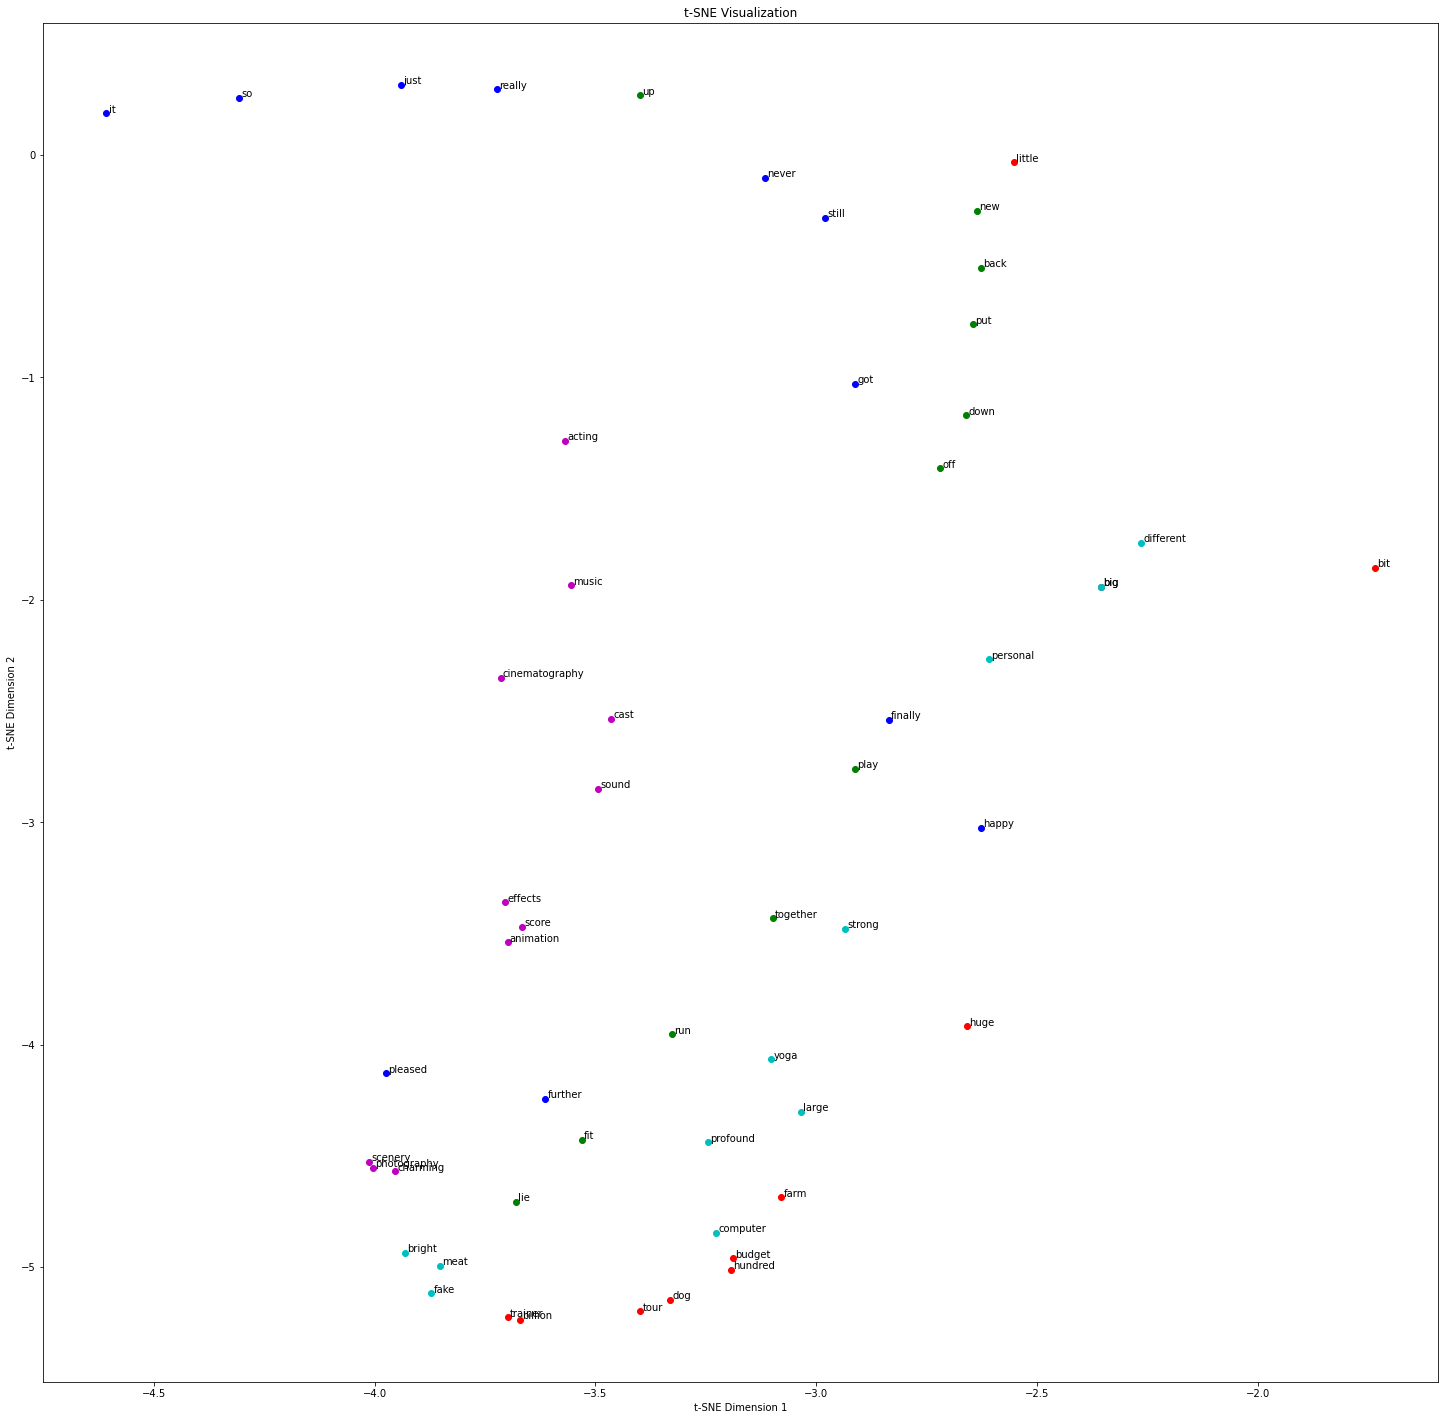

In [ ]:
def tsne(words, embeddings):
    word_indices = [word_to_idx[word] for word in words]
    top_k = 10
    similar_word_indices = []
    for word in words:
        top_indices = find_nearest_words2(embeddings, word_to_idx, idx_to_word, word)
        similar_word_indices.append(top_indices)

    selected_words = [idx_to_word[similar_word_idx] for similar_word_indices_list in similar_word_indices for similar_word_idx in similar_word_indices_list]
    similar_vectors = np.vstack([embeddings[similar_word_idx] for similar_word_indices_list in similar_word_indices for similar_word_idx in similar_word_indices_list])
    tsne = TSNE(n_components=2, random_state=42)
    tsne_vectors = tsne.fit_transform(similar_vectors)
    colors = ['r', 'g', 'b', 'c', 'm']

    c = -1
    fig, ax = plt.subplots(figsize=(25,25))
    for ind, i in enumerate(tsne_vectors):
        if ind%11 == 0:
            c += 1
        color = colors[c]
        x_val = i[0]
        y_val = i[1]
        ax.scatter(x_val, y_val, color=color)
        ax.annotate(selected_words[ind], (x_val+0.005, y_val+0.005), fontsize=10)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization')

    plt.savefig('tsne')

words = ['dog', 'run', 'happy', 'computer', 'music']
model = cbow_word2vec(cbow.vocab_size, 100, 0).to(device)
model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/cbow_w2v.pth", map_location=torch.device("cpu")
    )
)
embeddings = model.in_embeddings.weight.data.cpu().numpy()
tsne(words, word_embeddings)

In [ ]:
# class skipgram_word2vec(nn.Module):
#     def __init__(self, vocab_size, embed_size, hidden_size, pad_val=0, window_size=2):
#         super(skipgram_word2vec, self).__init__()
#         self.in_embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=pad_val)
#         self.out_embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=pad_val)
#         self.pred = torch.tensor([])
        
#     def forward(self, i, o, neg):
#         # in_embeds = self.in_embeddings(i)
#         in_embeds = self.in_embeddings(i).view((1,-1))
#         out_embeds = self.in_embeddings(o).view((1,-1))
#         # out_embeds = self.out_embeddings(o)
        
#         # self.pred = out_embeds
#         # pos_val = F.logsigmoid(torch.bmm(out_embeds, in_embeds.unsqueeze(2)).squeeze(2).sum(1))
#         # neg_embeds = self.out_embeddings(neg)
#         # neg_val = - F.logsigmoid(torch.bmm(neg_embeds, in_embeds.unsqueeze(2)).squeeze(2).sum(1))
#         # return - (pos_val + neg_val).mean()
#         score = torch.mm(in_embeds, torch.t(out_embeds))
#         probs = F.logsigmoid(score)
#         return probs

#     def predict(self, idx):
#         return self.in_embeddings(idx)

In [ ]:
# class Skipgram_model():
#     def __init__(self, vocab_size, data, pad_val=0, hidden_size=64, batch_size=32,lr=0.001, num_epochs=10, window_size=2, embedding_size=64):
#         self.vocab_size = vocab_size
#         self.data = data
#         self.pad_val = pad_val
#         self.hidden_size = hidden_size
#         self.batch_size = batch_size
#         self.lr = lr
#         self.num_epochs = num_epochs
#         self.window_size = window_size
#         self.embedding_size = embedding_size
#         self.w2v = skipgram_word2vec(vocab_size, embedding_size, hidden_size, pad_val).to(device)
    
#     def train_skipgram_word2vec(self):
#         dataload = DataLoader(self.data, batch_size=self.batch_size, num_workers=0)
#         loss_func = nn.MSELoss().to(device)
#         optim = torch.optim.Adam(params=self.w2v.parameters(), lr=self.lr, weight_decay=1e-4)
#         for epoch in tqdm(range(self.num_epochs), desc='epoch'):
#             self.w2v.train()
#             total_loss = 0
#             total_acc = 0
#             for ind, i in enumerate(dataload):
#                 inp, out, neg = map(lambda x:x.to(device), i)
#                 # inp = i[0].to(device)
#                 # out = i[1].to(device)
#                 # neg = i[2].to(device)

#                 optim.zero_grad()
#                 # loss = self.w2v(inp, out, neg)
#                 probs = self.w2v(inp, out, neg)
#                 # print(probs[0], neg)
#                 # loss = loss_func(probs[0].squeeze(0), neg.float())
#                 loss = loss_func(probs[0], neg.float().squeeze(0).sum(0).unsqueeze(0))
#                 loss.backward()
#                 optim.step()

#                 total_loss += loss.item()  
#                 if ind%10000 == 0:
#                     print(ind/len(self.data))  
#             print(f'\tEpoch {epoch + 1}\tTrain Loss: {total_loss}')
#         torch.save(self.w2v.state_dict(), 'skipgram_w2v.pth')
        
#     def load_model(self):
#         self.w2v.load_state_dict(
#             torch.load(
#                 "/content/drive/MyDrive/skipgram_w2v.pth", map_location=torch.device("cpu")
#             )
#         )
#         return self.w2v

#     def nearest_words(self,word, word_to_idx, idx_to_word, num=10):
#         try:
#             idx = word_to_idx[word]
#         except:
#             idx = word_to_idx['<UNK>']
#         emb = self.w2v.predict(torch.tensor(idx).to(device)).unsqueeze(0)
#         sims = torch.mm(emb, self.w2v.in_embeddings.weight.transpose(0,1)).squeeze(0)
#         sims = (-sims).sort()[1][0: num+1]
#         tops = list()
#         for k in range(num):
#             tops.append(idx_to_word[sims[k].item()])
#         return tops

In [ ]:
# w2v_skipgram = Skipgram_model(cbow.vocab_size, cbow.data_skip)
# w2v_skipgram.train_skipgram_word2vec()
# # model = w2v_skipgram.load_model()

In [ ]:
# # w2v_cbow.load_model()
# word = "titanic"
# w2v_skipgram.nearest_words(word, word_to_idx, idx_to_word)